# Biweekly Report 4
## Allison Liu
## APPM 5720

In this notebook, I compare two generative architectures-- a variational autoencoder (VAE) and a generative adversarial network (GAN)-- on a subset of the CelebA dataset, a large-scale face attribute dataset of over 200k celebrity faces. Unfortunately, the training of the GAN wasn't successful, but report, I plan on focusing primarily on GANs.

I knew going into this that GANs typically perform better as genearative models, but I wanted to test it for myself. The goal of this biweekly report was to compare a variational autoencoder (VAE) with a generative adversarial network (GAN). Additionally, I have worked with GANs before, so this notebook goes slightly more in-depth in the VAE implementation because I wanted to get more exposure to VAEs. This notebook was not aimed at optimizing the performance of a GAN, but rather to simply explore and compare implementations of the two architectures. I would have liked to implement a hybrid VAE-GAN to compare and plan to implement it in the future! I'd also love to try to generate higher-quality images at some point and do super-resolution. This was done in Google Colab, without GPU resources.

I use the following 2 tutorials as guides for this report:
* https://towardsdatascience.com/gans-vs-autoencoders-comparison-of-deep-generative-models-985cf15936ea

* https://goodboychan.github.io/python/coursera/tensorflow_probability/icl/2021/09/14/03-Variational-AutoEncoder-Celeb-A.html

The dataset can be found here:
* Dataset website: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html 
* https://www.kaggle.com/jessicali9530/celeba-dataset/version/2?select=img_align_celeba 

* subsampled dataset (Imperial College London): https://drive.google.com/file/d/1qzbcYRjxO6yU_usb4CXyGObUEjIVYWAp/view



# 1. Data

I use a subset of the Celeb A dataset to build facial generative models.

> CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including

> - 10,177 number of identities,
> - 202,599 number of face images, and
> - 5 landmark locations, 40 binary attributes annotations per image.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile

tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.8.0
Tensorflow Probability Version:  0.16.0


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Unzip the dataset
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Spring2022/APPM5720/CelebA_subset.zip", 'r')
zip_ref.extractall()
zip_ref.close()

Load the data set

In [5]:
# Function for loading the images

def load_image(filepath):
    raw_img = tf.io.read_file(filepath) 
    img_tensor_int = tf.image.decode_jpeg(raw_img, channels=3)
    img_tensor_flt = tf.image.convert_image_dtype(img_tensor_int, tf.float32)
    return img_tensor_flt, img_tensor_flt

def load_dataset(split):
    train_list_ds = tf.data.Dataset.list_files('/content/{}/*.jpg'.format(split), shuffle=False)
    train_ds = train_list_ds.map(load_image)
    return train_ds

In [6]:
train_ds = load_dataset('train')
val_ds = load_dataset('val')
test_ds = load_dataset('test')

## EDA
I only did a brief EDA on this dataset, since I really wanted to get to exploring model architectures. I essentially only did enough to confirm the major documented details on the subsampled CelebA dataset.

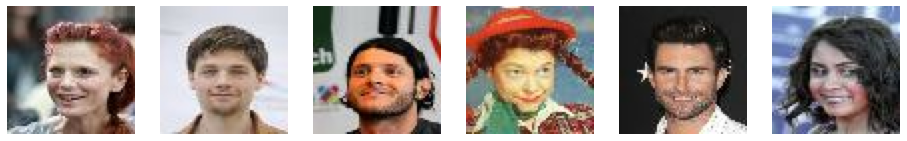

In [7]:
# Display a few examples
n_examples_shown = 6
f, axs = plt.subplots(1, n_examples_shown, figsize=(16, 3))

for j, image in enumerate(train_ds.take(n_examples_shown)):
    axs[j].imshow(image[0])
    axs[j].axis('off')

In [8]:
train_path = [os.path.join('./train', filename) for filename in os.listdir('train')]
val_path = [os.path.join('./val', filename) for filename in os.listdir('val')]
test_path = [os.path.join('./test', filename) for filename in os.listdir('test')]

print(f'Num train: {len(train_path)}')
print(f'Num val: {len(val_path)}')
print(f'Num test: {len(test_path)}')

print(f'Image shape: {np.shape(plt.imread(train_path[0]))}')

Num train: 10000
Num val: 1000
Num test: 1000
Image shape: (64, 64, 3)


In [9]:
# now load attribute
import pandas as pd
attr = pd.read_csv('list_attr_celeba_subset.csv')
attr = attr.set_index('image_id')

# check if attribute successful loaded
attr.describe()

,Unnamed: 0,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.00000
mean,5999.50000,-0.771000,-0.461167,0.017667,-0.606500,-0.960167,-0.694500,-0.522333,-0.531500,-0.522167,...,-0.88500,-0.020500,-0.577333,-0.368000,-0.617167,-0.904333,-0.050167,-0.752833,-0.860500,0.55100
std,3464.24595,0.636862,0.887351,0.999886,0.795117,0.279440,0.719523,0.852777,0.847094,0.852879,...,0.46561,0.999832,0.816543,0.929865,0.786865,0.426845,0.998782,0.658239,0.509472,0.83454
min,0.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000
25%,2999.75000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.00000
50%,5999.50000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.00000
75%,8999.25000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.00000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.00000
max,11999.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


There are 10,000 training images, 1000 validation images, and 1000 test images. Each image has a shape of (64, 64, 3).

There is also a table of attributes which label the images. These attributes can be used to modify the generated image, though I will not be using them in this notebook.

In [10]:
# Batch the Dataset objects
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

# 2. Building and Training a Variational Autoencoder Model

Create and compile a Convolutional Variational Autoencoder Model (including encoder and decoder) for the celebrity faces dataset. Print summaries for the encoder, decoder and full autoencoder models in order to check the architecture of the network. Then train the model on the images in the celebA dataset.

In [11]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Flatten, Dense, UpSampling2D, Reshape

In [12]:
def get_prior(num_modes, latent_dim):
    prior = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=[1 / num_modes,] * num_modes),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=tf.Variable(tf.random.normal(shape=[num_modes, latent_dim])),
            scale_diag=tfp.util.TransformedVariable(tf.Variable(tf.ones(shape=[num_modes, latent_dim])), bijector=tfb.Softplus())
        )
    )
    return prior

def get_kl_regularizer(prior_distribution):
    divergence_regularizer = tfpl.KLDivergenceRegularizer(
        prior_distribution,
        use_exact_kl=False,
        weight=1.0,
        test_points_fn=lambda q: q.sample(3),
        test_points_reduce_axis=(0, 1)
    )
    return divergence_regularizer

prior = get_prior(num_modes=2, latent_dim=50)
kl_regularizer = get_kl_regularizer(prior)

In [13]:
def get_encoder(latent_dim, kl_regularizer):
    encoder = Sequential([
        Conv2D(32, (4, 4), activation='relu', strides=2, padding='SAME', input_shape=(64, 64, 3)),
        BatchNormalization(),
        Conv2D(64, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(128, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Conv2D(256, (4, 4), activation='relu', strides=2, padding='SAME'),
        BatchNormalization(),
        Flatten(),
        Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim)),
        tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=kl_regularizer)
    ])
    return encoder

encoder = get_encoder(latent_dim=50, kl_regularizer=kl_regularizer)

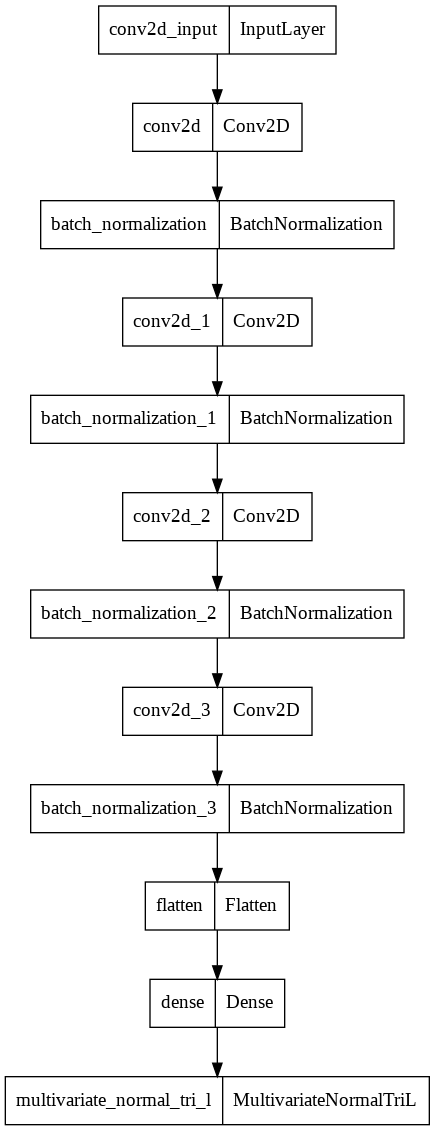

In [14]:
tf.keras.utils.plot_model(encoder)

This tensorflow function to show encoder/decoder architectures is awesome!

#### Define decoder network

In [15]:
def get_decoder(latent_dim):
    decoder = Sequential([
        Dense(4096, activation='relu', input_shape=(latent_dim, )),
        Reshape((4, 4, 256)),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='SAME'),
        UpSampling2D(size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='SAME'),
        Conv2D(3, (3, 3), padding='SAME'),
        Flatten(),
        tfpl.IndependentBernoulli(event_shape=(64, 64, 3))
    ])
    return decoder

decoder = get_decoder(latent_dim=50)

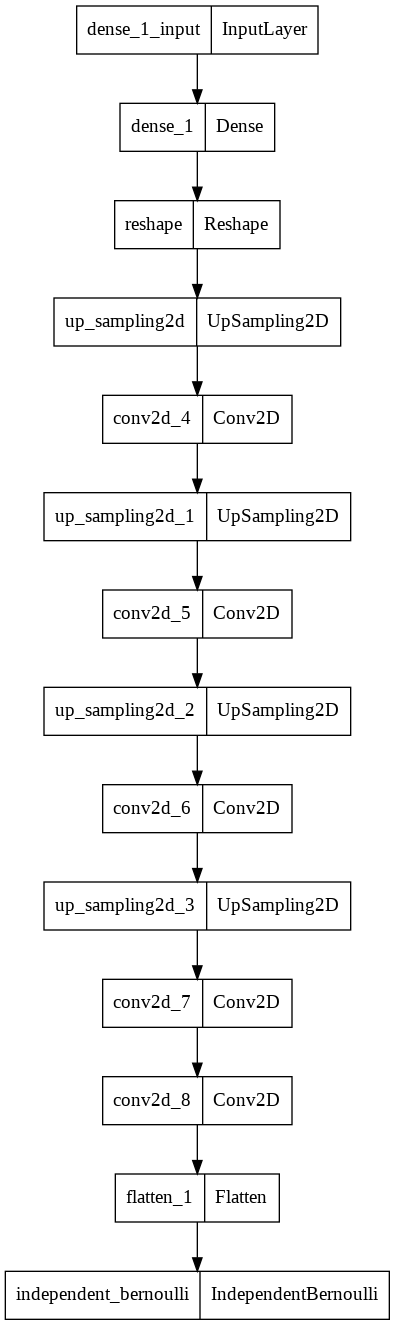

In [16]:
tf.keras.utils.plot_model(decoder)

Define reconstruction loss

In [17]:
def reconstruction_loss(batch_of_images, decoding_dist):
    """
    The function takes batch_of_images (Tensor containing a batch of input images to
    the encoder) and decoding_dist (output distribution of decoder after passing the 
    image batch through the encoder and decoder) as arguments.
    The function should return the scalar average expected reconstruction loss.
    """
    return -tf.reduce_mean(decoding_dist.log_prob(batch_of_images), axis=0)

#### Create and make a summary of the model.

In [18]:
vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs))

In [19]:
print("encoder summary:")
encoder.summary()
print("\ndecoder summary:")
decoder.summary()
print("\nvae summary:")
vae.summary()

encoder summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        1568      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        32832     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 batch_normalization_2 (Batc  (None, 8,

In [20]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=reconstruction_loss)

In [21]:
# vae.fit(train_ds, validation_data=val_ds, epochs=30)

# Get pretrained model
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Spring2022/APPM5720/pretrained_model.zip", 'r')
zip_ref.extractall('/content/pretrained_model')
zip_ref.close()

# load the pre-trained model

ckpt = tf.train.Checkpoint(model=vae)
ckpt.restore(tf.train.latest_checkpoint('/content/pretrained_model/model'))

In [22]:
test_loss = vae.evaluate(test_ds)
print("Test loss: {}".format(test_loss))

32/32 [==============================] - 14s 387ms/step - loss: 6157.4668
Test loss: 6157.466796875


Choose some images of the training set, run them through the encoder to parameterize the latent code, and then reconstruct the images with the decoder.

In [23]:
def reconstruct(encoder, decoder, batch_of_images):
    """
    The function takes the encoder, decoder and batch_of_images as inputs, which
    should be used to compute the reconstructions.
    The function should then return the reconstructions Tensor.
    """
    approx_posterior = encoder(batch_of_images)
    decoding_dist = decoder(approx_posterior.mean())
    return decoding_dist.mean()

n_reconstructions = 7
files = [f for f in os.listdir('/content/test/') if f.endswith('.jpg')]
num_test_files = len(files)
test_ds_for_reconstructions = load_dataset('test')
for all_test_images, _ in test_ds_for_reconstructions.batch(num_test_files).take(1):
    all_test_images_np = all_test_images.numpy()
example_images = all_test_images_np[np.random.choice(num_test_files, n_reconstructions, replace=False)]

reconstructions = reconstruct(encoder, decoder, example_images).numpy()

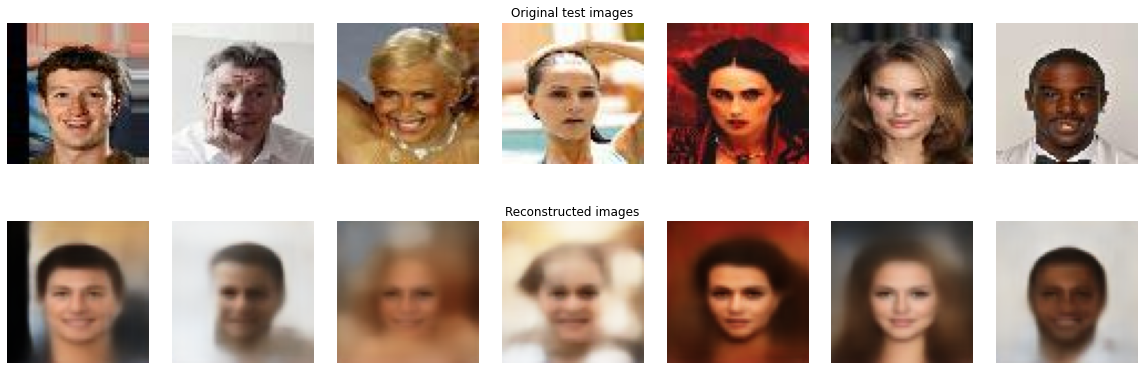

In [24]:
f, axs = plt.subplots(2, n_reconstructions, figsize=(16, 6))
axs[0, n_reconstructions // 2].set_title("Original test images")
axs[1, n_reconstructions // 2].set_title("Reconstructed images")
for j in range(n_reconstructions):
    axs[0, j].imshow(example_images[j])
    axs[1, j].imshow(reconstructions[j])
    axs[0, j].axis('off')
    axs[1, j].axis('off')
    
plt.tight_layout();

These generated faces are incredibly creepy. The reconstructed images share many similarities with the originals. Notably, the new images are a bit blurry, which is a known phenomenon of VAEs.  This has been hypothesized to be due to the fact that variational inference optimizes a lower bound to the likelihood, not the actual likelihood itself.

## Sample new images from the generative model

Now, sample 10 latent codes and decode them to generate new celebrity faces.  The images generated by our model are of similar styles with the training images, they are also realistic and have a good variation, meaning we are not suffering from modal collapse. No less creepy.

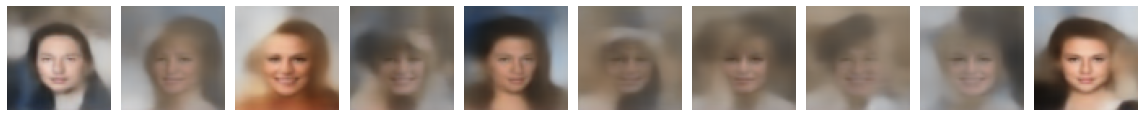

In [25]:
def generate_images(prior, decoder, n_samples):
    """
    The function takes the prior distribution, decoder and number of samples as inputs, which
    should be used to generate the images.
    The function should then return the batch of generated images.
    """
    z = prior.sample(n_samples)
    return decoder(z).mean()

n_samples = 10
sampled_images = generate_images(prior, decoder, n_samples)

f, axs = plt.subplots(1, n_samples, figsize=(16, 6))

for j in range(n_samples):
    axs[j].imshow(sampled_images[j])
    axs[j].axis('off')
    
plt.tight_layout();

# 3. Building and Training a DCGAN Model

Now, build a convolutional GAN on the same data and compare this to our above variational autoencoder. The training failed spectacularly on this and the outputted images look like noise :(

Create and compile a DC-GAN model, and print the summary.

In [26]:
# Create and compile a DC-GAN model, and print the summary

from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, LeakyReLU,\
      BatchNormalization, Conv2DTranspose, Conv2D, Reshape
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
from skimage.transform import resize

def generator_model(latent_dim=100, leaky_alpha=0.2, init_stddev=0.02):

    g = Sequential()
    g.add(Dense(4*4*512, input_shape=(latent_dim,),
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(Reshape(target_shape=(4, 4, 512)))
    g.add(BatchNormalization())
    g.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    g.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same',
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(BatchNormalization())
    g.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    g.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', 
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(BatchNormalization())
    g.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    g.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', 
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(Activation('tanh'))
    g.summary()
    #g.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001, beta_1=0.5), metrics=['accuracy'])
    return g

  
def discriminator_model(leaky_alpha=0.2, init_stddev=0.02):
    
    d = Sequential()
    d.add(Conv2D(64, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_stddev),
               input_shape=(32, 32, 3)))
    d.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    d.add(Conv2D(128, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_stddev)))
    d.add(BatchNormalization())
    d.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    d.add(Conv2D(256, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_stddev)))
    d.add(BatchNormalization())
    d.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    d.add(Flatten())
    d.add(Dense(1, kernel_initializer=RandomNormal(stddev=init_stddev)))
    d.add(Activation('sigmoid'))
    d.summary()
    return d

def DCGAN(sample_size=100):
    # Generator
    g = generator_model(sample_size, 0.2, 0.02)

    # Discriminator
    d = discriminator_model(0.2, 0.02)
    d.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.5), loss='binary_crossentropy')
    d.trainable = False
    # GAN
    gan = Sequential([g, d])
    gan.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.5), loss='binary_crossentropy')
    
    return gan, g, d

In [27]:
def load_image(filename, size=(32, 32)):
    img = plt.imread(filename)
    # crop
    rows, cols = img.shape[:2]
    crop_r, crop_c = 150, 150
    start_row, start_col = (rows - crop_r) // 2, (cols - crop_c) // 2
    end_row, end_col = rows - start_row, cols - start_row
    img = img[start_row:end_row, start_col:end_col, :]
    # resize
    img = resize(img, size)
    return img

def preprocess(x):
    return (x/255)*2-1

def deprocess(x):
    return np.uint8((x+1)/2*255)

def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])  

def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Validation Losses")
    plt.legend()
    plt.show()

def show_images(generated_images):
    n_images = len(generated_images)
    cols = 5
    rows = n_images//cols
    
    plt.figure(figsize=(8, 6))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

#### Train the model.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              827392    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 batch_normalization_4 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        3277056   
 nspose)                                                         
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 256)       

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch:   1/3 Discriminator Loss: 4.7341 Generator Loss: 2.5217


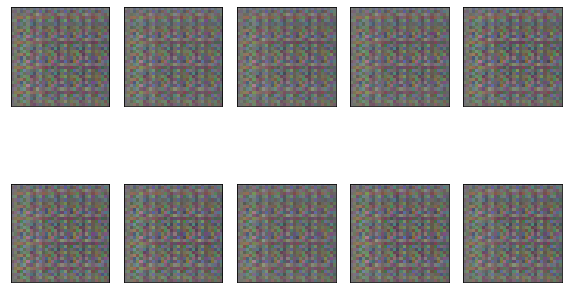

--------------- Epoch 2 ---------------


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch:   2/3 Discriminator Loss: 2.6421 Generator Loss: 4.0139


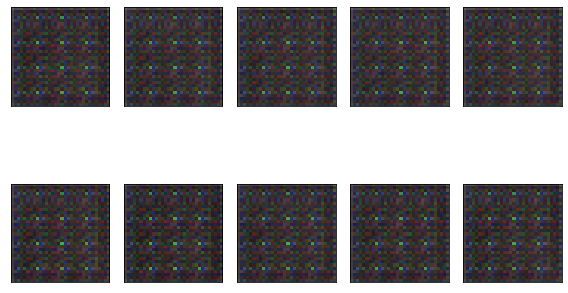

--------------- Epoch 3 ---------------


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch:   3/3 Discriminator Loss: 4.6350 Generator Loss: 3.7341


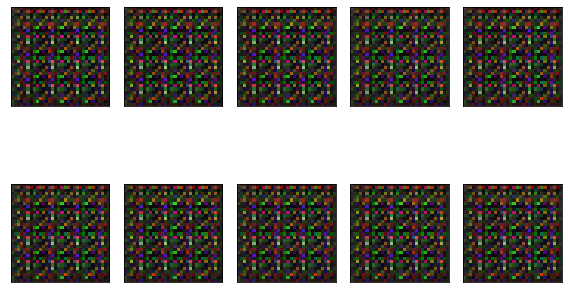

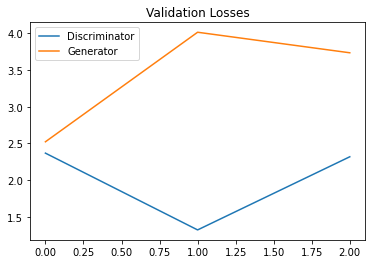

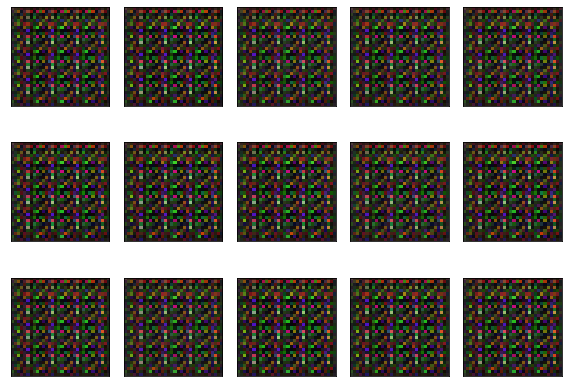

In [28]:
def train(sample_size=100, epochs=3, batch_size=128, eval_size=16, smooth=0.1):

    batchCount=len(train_path)//batch_size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)

    
    # create a GAN, a generator and a discriminator
    gan, g, d = DCGAN(sample_size)
    
    losses = []

    for e in range(epochs):
        print('-'*15, 'Epoch %d' % (e+1), '-'*15)
        for i in tqdm(range(batchCount)):
            
            path_batch = train_path[i*batch_size:(i+1)*batch_size]
            image_batch = np.array([preprocess(load_image(filename)) for filename in path_batch])
      

            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            generated_images = g.predict_on_batch(noise)

            # Train discriminator on generated images
            d.trainable = True
            d.train_on_batch(image_batch, y_train_real*(1-smooth))
            d.train_on_batch(generated_images, y_train_fake)

            # Train generator
            d.trainable = False
            g_loss=gan.train_on_batch(noise, y_train_real)
        
        # evaluate
        test_path = np.array(val_path)[np.random.choice(len(val_path), eval_size, replace=False)]
        x_eval_real = np.array([preprocess(load_image(filename)) for filename in test_path])

        noise = np.random.normal(loc=0, scale=1, size=(eval_size, sample_size))
        x_eval_fake = g.predict_on_batch(noise)
        
        d_loss  = d.test_on_batch(x_eval_real, y_eval_real)
        d_loss += d.test_on_batch(x_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(noise, y_eval_real)
        
        losses.append((d_loss/2, g_loss))
  
        print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
            e+1, epochs, d_loss, g_loss))  
        
        show_images(x_eval_fake[:10])
    
    # show the result
    show_losses(losses)
    show_images(g.predict(np.random.normal(loc=0, scale=1, size=(15, sample_size))))    
    return g
    

noise_dim=100
train()

So this training didn't work out too well. I just wasn't able to train for long enough due to computational resource limitations. Next week, I'll try to find some pretrained GAN models.

In the tutorial, the generated images looked reasonable.  While the quality of images is not as good as those in the training set (because they were reshaped), the faces are close enough to reality.  Compared with images produced by VAE, the images that were generated in the tutorial are arguably more creative and realistic. They are still pretty creepy though...I'd love to try to generate higher-quality images at some point and do super-resolution as well.